In [12]:
from gridworld import GridworldEnv

In [13]:
env = GridworldEnv()

In [14]:
env.reset()

(np.int64(1), {})

In [15]:
env.P[2][0]

[(1.0, np.int64(2), -1, np.False_)]

In [16]:
action = env.action_space.sample()
action

env.step(action)

(np.int64(5), -1, np.False_, False, {})

In [17]:
total_reward = 0.0
total_steps = 0
env.reset()
while True:
    action = env.action_space.sample()
    obs, reward, is_done, is_trunc, _ = env.step(action)
    total_reward += reward
    total_steps += 1
    # env.render()
    if is_done:
        break
print(total_reward)

-6.0


[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]]


Text(0.5, 1.0, 'Grid')

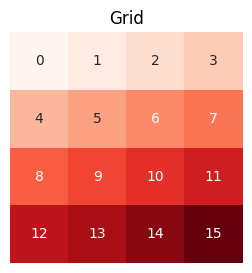

In [18]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

shape = (4, 4)
gw = np.zeros(shape)
for s in range(env.nS):
    position = np.unravel_index(s, shape)
    gw[position] = s

print(gw)

plt.figure(figsize=(3, 3))
ax = sns.heatmap(
    gw,
    cmap="Reds",
    annot=True,
    fmt=".0f",
    cbar=False,
    xticklabels=False,
    yticklabels=False,
)
ax.set_title("Grid")


In [19]:
import numpy as np

nS = env.observation_space.n  # Number of states
nA = env.action_space.n  # Number of actions

# Initialize a 3D transition matrix
transition_matrix_3d = np.zeros((nS, nS, nA))

for s in range(nS):
    for a in range(nA):
        for prob, next_state, reward, done in env.P[s][a]:
            transition_matrix_3d[s, next_state, a] += prob

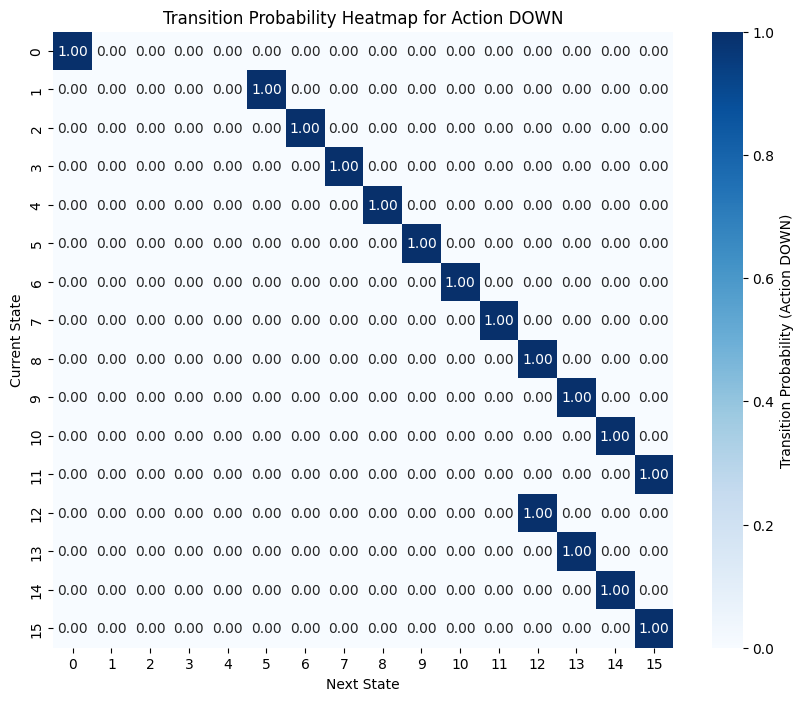

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: visualize transitions for action 0 (UP)

actions = dict(UP=0, RIGHT=1, DOWN=2, LEFT=3)
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3


action = "DOWN"
action_idx = actions[action]
plt.figure(figsize=(10, 8))
sns.heatmap(
    transition_matrix_3d[:, :, action_idx],
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={"label": f"Transition Probability (Action {action})"},
)
plt.title(f"Transition Probability Heatmap for Action {action}")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.show()


In [21]:
# Policy Iteration


def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment.

    Args:
        policy:[S, A]shaped matrix representing the policy. Random in our case
        env: OpenAI env. env.P -> transition dynamics of the environment.
            env.P[s][a] [(prob, next_state, reward, done)].
            env.nS is number of states in the environment.
            env.nA is number of actions in the environment.
        theta: Stop iteration once value function change is
            less than theta for all states.
        discount_factor: Gamma discount factor.

    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a (all 0) value function
    V = np.zeros(env.nS)
    V_new = np.copy(V)
    while True:
        delta = 0
        # For each state, perform a "backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, pi_a in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value as per backup diagram
                    v += pi_a * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            V_new[s] = v
            delta = max(delta, np.abs(V_new[s] - V[s]))
        V = np.copy(V_new)
        # Stop if change is below a threshold
        if delta < theta:
            break
    return np.array(V)

In [22]:
# Custom print to show state values inside the grid
def grid_print(V, k=None):
    ax = sns.heatmap(
        V.reshape(env.shape),
        annot=True,
        square=True,
        cbar=False,
        cmap="Blues",
        xticklabels=False,
        yticklabels=False,
    )

    if k:
        ax.set(title="K = {0}".format(k))
    plt.show()

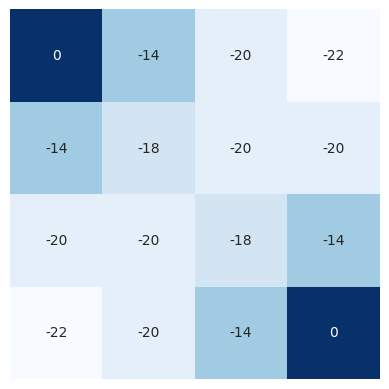

In [23]:
# Create a random policy
random_policy = np.ones([env.nS, env.nA]) / env.nA

# run policy iteration for random policy
V_pi = policy_eval(random_policy, env, discount_factor=1.0, theta=0.00001)

# Print policy
grid_print(V_pi.reshape(env.shape))

In [24]:
env.nA

4

In [25]:
random_policy

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

In [26]:
# Policy Improvement


def policy_improvement(policy, V, env, discount_factor=1.0):
    """
    Improve a policy given an environment and a full description
    of the environment's dynamics and the state-values V.

    Args:
        policy: [S, A] shaped matrix representing the policy.
        V: current state-value for the given policy
        env: OpenAI env. env.P -> transition dynamics of the environment.
            env.P[s][a] [(prob, next_state, reward, done)].
            env.nS is number of states in the environment.
            env.nA is number of actions in the environment.
        discount_factor: Gamma discount factor.

    Returns:
        policy: [S, A] shaped matrix representing improved policy.
        policy_changed: boolean which has value of `True` if there
                        was a change in policy
    """

    def argmax_a(arr):
        """
        Return idxs of all max values in an array.
        """
        max_idx = []
        max_val = float("-inf")
        for idx, elem in enumerate(arr):
            if elem == max_val:
                max_idx.append(idx)
            elif elem > max_val:
                max_idx = [idx]
                max_val = elem
        return max_idx

    policy_changed = False
    Q = np.zeros([env.nS, env.nA])
    new_policy = np.zeros([env.nS, env.nA])

    # For each state, perform a "greedy improvement"
    for s in range(env.nS):
        old_action = np.array(policy[s])
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[s][a]:
                # Calculate the expected value as per backup diagram
                Q[s, a] += prob * (reward + discount_factor * V[next_state])

        # get maximizing actions and set new policy for state s
        best_actions = argmax_a(Q[s])
        new_policy[s, best_actions] = 1.0 / len(best_actions)

    if not np.allclose(new_policy[s], policy[s]):
        policy_changed = True

    return new_policy, policy_changed

In [27]:
policy, changed = policy_improvement(random_policy, V_pi, env, discount_factor=1.0)

In [28]:
changed

False

In [29]:
policy

array([[0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.5 , 0.5 ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.  , 0.  , 0.5 ],
       [0.  , 0.  , 0.5 , 0.5 ],
       [0.  , 0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25]])

In [30]:
V_pi = policy_eval(policy, env, discount_factor=1.0, theta=0.00001)


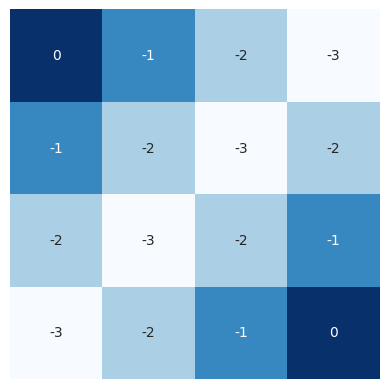

In [31]:
# Print policy
grid_print(V_pi.reshape(env.shape))

In [36]:
policy

array([[0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.5 , 0.5 ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.  , 0.  , 0.5 ],
       [0.  , 0.  , 0.5 , 0.5 ],
       [0.  , 0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.5 , 0.5 , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25]])

In [49]:
obs = env.reset()

In [52]:
np.argmax(policy[obs[0]])

np.int64(1)

In [61]:
obs

np.int64(4)

In [82]:
total_reward = 0.0
total_steps = 0

(state,_) = env.reset()
print(state)
while True:
    action = np.argmax(policy[state])
    state, reward, is_done, is_trunc, _ = env.step(action)
    total_reward += reward
    total_steps += 1
    # env.render()
    if is_done:
        break
print(total_reward)

11
-1.0


In [47]:
obs

np.int64(0)